In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import matplotlib
from xgboost import plot_importance
%matplotlib inline

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 데이터 전처리

* 학습 데이터를 DataFrame으로 로딩
* target값 컬럼을 포함한 피처가 371개 존재

In [2]:
cust_df = pd.read_csv("./santander-customer-satisfaction/train_santander.csv",encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


* 111개 피처가 float형, 206개 피처가 int형
* 모든 피처가 숫자형이며 Null값이 없다.

In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


* 전체 데이터에서 만족과 불만족의 비율 확인
* 만족 96% 불만족 4%

In [4]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [5]:
cust_df.describe( ).T

,count,mean,std,min,25%,50%,75%,max
ID,76020.0,75964.050723,43781.947379,1.00,38104.7500,76043.00,113748.7500,151838.00
var3,76020.0,-1523.199277,39033.462364,-999999.00,2.0000,2.00,2.0000,238.00
var15,76020.0,33.212865,12.956486,5.00,23.0000,28.00,40.0000,105.00
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.00,0.0000,0.00,0.0000,210000.00
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.00,0.0000,0.00,0.0000,12888.03
...,...,...,...,...,...,...,...,...
saldo_medio_var44_hace3,76020.0,1.858575,147.786584,0.00,0.0000,0.00,0.0000,24650.01
saldo_medio_var44_ult1,76020.0,76.026165,4040.337842,0.00,0.0000,0.00,0.0000,681462.90
saldo_medio_var44_ult3,76020.0,56.614351,2852.579397,0.00,0.0000,0.00,0.0000,397884.30
var38,76020.0,117235.809430,182664.598503,5163.75,67870.6125,106409.16,118756.2525,22034738.76


* var3 컬럼의 경우 min 값이 -999999임 NaN이나 특정 예외값을 변환한것으로 예상
* var3은 숫자 형이고, 다른 값에 비해 -999999는 너무 편차가 심하므로 가장 값이 많은 2로 변환
* ID피처는 단순 식별자에 불과하므로 피처를 드롭
* 클래스 데이터 세트와 피처 데이터 세트를 분리해 별도의 데이터 셋으로 저장

In [6]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999,2, inplace=True)
cust_df.drop('ID',axis=1 , inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))


피처 데이터 shape:(76020, 369)


* 학습과 성능 평가를 위해서 원본 데이터 셋에서 Train/Test set 분리
* 비대칭항 데이터 셋이므로 클래스인 Target 값 분포도가 Train data와 Test data에 고르게 추출됐는지 확인

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


#### XGBoost 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가
* n_estimators : weak learner의 개수 - 500
* early_stopping_rounds : 조기 중단할 반복 횟수 - 100


In [8]:
# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))



/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84054
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88072	validation_1-auc:0.84117
[16]	validation_0-auc:0.88238	validation_1-auc:0.84101
[17]	validation_0-auc:0.88354	validation_1-auc:0.84071
[18]	validation_0-au

#### 하이퍼 파라미터 튜닝
* 칼럼의 개수가 많으므로 과적합 가능성을 가정하고, max_depth, min_child_weight, colsample_bytree만 튜닝
* max_depth
    * 트리의 최대 깊이
* min_child_weight
    * 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 weight 총합, 클수록 분할을 자제하며 과적합을 조절하기 위해 사용
* colsample_bytree
    * 트리 생성에 필요한 피처를 임의로 샘플링하는데 사용, 매우 많은 피처가 있는 경우 과적합을 조정하는데 적용

In [9]:
# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7] , 'min_child_weight':[1,3] ,'colsample_bytree':[0.5, 0.75] }

# cv는 3으로 지정, 성능 평가 기준이 ROC AUC이므로 eval_metric = auc로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72220	validation_1-auc:0.72732
[1]	validation_0-auc:0.73513	validation_1-auc:0.73851
[2]	validation_0-auc:0.81328	validation_1-auc:0.81902
[3]	validation_0-auc:0.82198	validation_1-auc:0.82516
[4]	validation_0-auc:0.83082	validation_1-auc:0.83442
[5]	validation_0-auc:0.83232	validation_1-auc:0.83225
[6]	validation_0-auc:0.83027	validation_1-auc:0.83048
[7]	validation_0-auc:0.83946	validation_1-auc:0.83795
[8]	validation_0-auc:0.83789	validation_1-auc:0.83474
[9]	validation_0-auc:0.83574	validation_1-auc:0.83253
[10]	validation_0-auc:0.84507	validation_1-auc:0.83837
[11]	validation_0-auc:0.84854	validation_1-auc:0.83927
[12]	validation_0-auc:0.85111	validation_1-auc:0.83835
[13]	validation_0-auc:0.85258	validation_1-auc:0.83676
[14]	validation_0-auc:0.85447	validation_1-auc:0.83708
[15]	validation_0-auc:0.85639	validation_1-auc:0.83754
[16]	validation_0-auc:0.85745	validation_1-auc:0.83598
[17]	validation_0-auc:0.85845	validation_1-auc:0.83724
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.70913	validation_1-auc:0.71991
[1]	validation_0-auc:0.73241	validation_1-auc:0.73977
[2]	validation_0-auc:0.81520	validation_1-auc:0.81881
[3]	validation_0-auc:0.82575	validation_1-auc:0.82698
[4]	validation_0-auc:0.83703	validation_1-auc:0.83613
[5]	validation_0-auc:0.84110	validation_1-auc:0.83536
[6]	validation_0-auc:0.83962	validation_1-auc:0.83714
[7]	validation_0-auc:0.84471	validation_1-auc:0.83745
[8]	validation_0-auc:0.84368	validation_1-auc:0.83491
[9]	validation_0-auc:0.84142	validation_1-auc:0.83409
[10]	validation_0-auc:0.84969	validation_1-auc:0.83703
[11]	validation_0-auc:0.85247	validation_1-auc:0.83922
[12]	validation_0-auc:0.85486	validation_1-auc:0.83894
[13]	validation_0-auc:0.85653	validation_1-auc:0.83878
[14]	validation_0-auc:0.85761	validation_1-auc:0.83765
[15]	validation_0-auc:0.85940	validation_1-auc:0.83839
[16]	validation_0-auc:0.85977	validation_1-auc:0.83825
[17]	validation_0-auc:0.86104	validation_1-auc:0.83951
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.69700	validation_1-auc:0.70340
[1]	validation_0-auc:0.73289	validation_1-auc:0.73540
[2]	validation_0-auc:0.81670	validation_1-auc:0.81105
[3]	validation_0-auc:0.83054	validation_1-auc:0.82589
[4]	validation_0-auc:0.83677	validation_1-auc:0.82978
[5]	validation_0-auc:0.83828	validation_1-auc:0.83194
[6]	validation_0-auc:0.83828	validation_1-auc:0.83341
[7]	validation_0-auc:0.84263	validation_1-auc:0.83412
[8]	validation_0-auc:0.84237	validation_1-auc:0.83341
[9]	validation_0-auc:0.84232	validation_1-auc:0.83262
[10]	validation_0-auc:0.84968	validation_1-auc:0.83710
[11]	validation_0-auc:0.85327	validation_1-auc:0.83806
[12]	validation_0-auc:0.85569	validation_1-auc:0.83908
[13]	validation_0-auc:0.85684	validation_1-auc:0.83850
[14]	validation_0-auc:0.85794	validation_1-auc:0.83859
[15]	validation_0-auc:0.86034	validation_1-auc:0.83965
[16]	validation_0-auc:0.86122	validation_1-auc:0.83938
[17]	validation_0-auc:0.86298	validation_1-auc:0.84058
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72207	validation_1-auc:0.72723
[1]	validation_0-auc:0.73687	validation_1-auc:0.74013
[2]	validation_0-auc:0.81378	validation_1-auc:0.81961
[3]	validation_0-auc:0.82266	validation_1-auc:0.82451
[4]	validation_0-auc:0.83247	validation_1-auc:0.83372
[5]	validation_0-auc:0.83642	validation_1-auc:0.83544
[6]	validation_0-auc:0.83249	validation_1-auc:0.83077
[7]	validation_0-auc:0.84021	validation_1-auc:0.83770
[8]	validation_0-auc:0.83855	validation_1-auc:0.83418
[9]	validation_0-auc:0.83615	validation_1-auc:0.83134
[10]	validation_0-auc:0.84633	validation_1-auc:0.83740
[11]	validation_0-auc:0.84861	validation_1-auc:0.83944
[12]	validation_0-auc:0.85061	validation_1-auc:0.83998
[13]	validation_0-auc:0.85196	validation_1-auc:0.84092
[14]	validation_0-auc:0.85336	validation_1-auc:0.83944
[15]	validation_0-auc:0.85556	validation_1-auc:0.84150
[16]	validation_0-auc:0.85659	validation_1-auc:0.84152
[17]	validation_0-auc:0.85771	validation_1-auc:0.84198
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.70841	validation_1-auc:0.71760
[1]	validation_0-auc:0.73166	validation_1-auc:0.73854
[2]	validation_0-auc:0.81662	validation_1-auc:0.81949
[3]	validation_0-auc:0.82754	validation_1-auc:0.82903
[4]	validation_0-auc:0.83738	validation_1-auc:0.83775
[5]	validation_0-auc:0.84076	validation_1-auc:0.83761
[6]	validation_0-auc:0.83902	validation_1-auc:0.83812
[7]	validation_0-auc:0.84368	validation_1-auc:0.83885
[8]	validation_0-auc:0.84266	validation_1-auc:0.83606
[9]	validation_0-auc:0.84082	validation_1-auc:0.83433
[10]	validation_0-auc:0.84810	validation_1-auc:0.83832
[11]	validation_0-auc:0.85093	validation_1-auc:0.83985
[12]	validation_0-auc:0.85286	validation_1-auc:0.84182
[13]	validation_0-auc:0.85369	validation_1-auc:0.84229
[14]	validation_0-auc:0.85411	validation_1-auc:0.84169
[15]	validation_0-auc:0.85639	validation_1-auc:0.84274
[16]	validation_0-auc:0.85711	validation_1-auc:0.84311
[17]	validation_0-auc:0.85818	validation_1-auc:0.84384
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.70992	validation_1-auc:0.71425
[1]	validation_0-auc:0.74018	validation_1-auc:0.73974
[2]	validation_0-auc:0.81489	validation_1-auc:0.81252
[3]	validation_0-auc:0.82851	validation_1-auc:0.82628
[4]	validation_0-auc:0.83564	validation_1-auc:0.83172
[5]	validation_0-auc:0.83740	validation_1-auc:0.83199
[6]	validation_0-auc:0.83723	validation_1-auc:0.83230
[7]	validation_0-auc:0.84310	validation_1-auc:0.83347
[8]	validation_0-auc:0.84279	validation_1-auc:0.83244
[9]	validation_0-auc:0.84028	validation_1-auc:0.83096
[10]	validation_0-auc:0.84741	validation_1-auc:0.83810
[11]	validation_0-auc:0.85115	validation_1-auc:0.83875
[12]	validation_0-auc:0.85346	validation_1-auc:0.84128
[13]	validation_0-auc:0.85392	validation_1-auc:0.83945
[14]	validation_0-auc:0.85448	validation_1-auc:0.83938
[15]	validation_0-auc:0.85643	validation_1-auc:0.84079
[16]	validation_0-auc:0.85693	validation_1-auc:0.84118
[17]	validation_0-auc:0.85952	validation_1-auc:0.84080
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72439	validation_1-auc:0.72737
[1]	validation_0-auc:0.73938	validation_1-auc:0.73942
[2]	validation_0-auc:0.81562	validation_1-auc:0.81645
[3]	validation_0-auc:0.83036	validation_1-auc:0.82345
[4]	validation_0-auc:0.84019	validation_1-auc:0.83140
[5]	validation_0-auc:0.84594	validation_1-auc:0.83409
[6]	validation_0-auc:0.84543	validation_1-auc:0.82949
[7]	validation_0-auc:0.85446	validation_1-auc:0.83333
[8]	validation_0-auc:0.85328	validation_1-auc:0.83011
[9]	validation_0-auc:0.85138	validation_1-auc:0.82921
[10]	validation_0-auc:0.85948	validation_1-auc:0.83570
[11]	validation_0-auc:0.86519	validation_1-auc:0.83706
[12]	validation_0-auc:0.86816	validation_1-auc:0.83672
[13]	validation_0-auc:0.86957	validation_1-auc:0.83495
[14]	validation_0-auc:0.87117	validation_1-auc:0.83292
[15]	validation_0-auc:0.87323	validation_1-auc:0.83516
[16]	validation_0-auc:0.87455	validation_1-auc:0.83507
[17]	validation_0-auc:0.87643	validation_1-auc:0.83566
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.71077	validation_1-auc:0.71902
[1]	validation_0-auc:0.73577	validation_1-auc:0.74042
[2]	validation_0-auc:0.82095	validation_1-auc:0.81861
[3]	validation_0-auc:0.83815	validation_1-auc:0.83096
[4]	validation_0-auc:0.84642	validation_1-auc:0.83655
[5]	validation_0-auc:0.85196	validation_1-auc:0.83716
[6]	validation_0-auc:0.85104	validation_1-auc:0.83579
[7]	validation_0-auc:0.85877	validation_1-auc:0.83711
[8]	validation_0-auc:0.85806	validation_1-auc:0.83593
[9]	validation_0-auc:0.85826	validation_1-auc:0.83425
[10]	validation_0-auc:0.86523	validation_1-auc:0.83838
[11]	validation_0-auc:0.86994	validation_1-auc:0.83865
[12]	validation_0-auc:0.87253	validation_1-auc:0.84046
[13]	validation_0-auc:0.87309	validation_1-auc:0.84103
[14]	validation_0-auc:0.87443	validation_1-auc:0.83968
[15]	validation_0-auc:0.87708	validation_1-auc:0.84094
[16]	validation_0-auc:0.87772	validation_1-auc:0.84170
[17]	validation_0-auc:0.87910	validation_1-auc:0.84249
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.70992	validation_1-auc:0.71081
[1]	validation_0-auc:0.74404	validation_1-auc:0.74272
[2]	validation_0-auc:0.82017	validation_1-auc:0.81563
[3]	validation_0-auc:0.83551	validation_1-auc:0.82595
[4]	validation_0-auc:0.84346	validation_1-auc:0.83063
[5]	validation_0-auc:0.84771	validation_1-auc:0.83389
[6]	validation_0-auc:0.84758	validation_1-auc:0.83100
[7]	validation_0-auc:0.85390	validation_1-auc:0.83135
[8]	validation_0-auc:0.85559	validation_1-auc:0.82946
[9]	validation_0-auc:0.85545	validation_1-auc:0.82562
[10]	validation_0-auc:0.86350	validation_1-auc:0.83294
[11]	validation_0-auc:0.86895	validation_1-auc:0.83498
[12]	validation_0-auc:0.87152	validation_1-auc:0.83802
[13]	validation_0-auc:0.87225	validation_1-auc:0.83687
[14]	validation_0-auc:0.87323	validation_1-auc:0.83478
[15]	validation_0-auc:0.87590	validation_1-auc:0.83753
[16]	validation_0-auc:0.87588	validation_1-auc:0.83708
[17]	validation_0-auc:0.87787	validation_1-auc:0.83887
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72375	validation_1-auc:0.72754
[1]	validation_0-auc:0.74058	validation_1-auc:0.73969
[2]	validation_0-auc:0.81581	validation_1-auc:0.81555
[3]	validation_0-auc:0.83176	validation_1-auc:0.82812
[4]	validation_0-auc:0.84028	validation_1-auc:0.83576
[5]	validation_0-auc:0.84506	validation_1-auc:0.83679
[6]	validation_0-auc:0.84401	validation_1-auc:0.83358
[7]	validation_0-auc:0.85267	validation_1-auc:0.83734
[8]	validation_0-auc:0.85146	validation_1-auc:0.83318
[9]	validation_0-auc:0.84991	validation_1-auc:0.83115
[10]	validation_0-auc:0.85726	validation_1-auc:0.83630
[11]	validation_0-auc:0.86184	validation_1-auc:0.83718
[12]	validation_0-auc:0.86435	validation_1-auc:0.83746
[13]	validation_0-auc:0.86503	validation_1-auc:0.83709
[14]	validation_0-auc:0.86592	validation_1-auc:0.83527
[15]	validation_0-auc:0.86806	validation_1-auc:0.83753
[16]	validation_0-auc:0.86835	validation_1-auc:0.83667
[17]	validation_0-auc:0.87012	validation_1-auc:0.83739
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.71171	validation_1-auc:0.71788
[1]	validation_0-auc:0.73693	validation_1-auc:0.74138
[2]	validation_0-auc:0.82320	validation_1-auc:0.82077
[3]	validation_0-auc:0.83940	validation_1-auc:0.83067
[4]	validation_0-auc:0.84688	validation_1-auc:0.83553
[5]	validation_0-auc:0.85056	validation_1-auc:0.83589
[6]	validation_0-auc:0.84834	validation_1-auc:0.83450
[7]	validation_0-auc:0.85583	validation_1-auc:0.83715
[8]	validation_0-auc:0.85399	validation_1-auc:0.83463
[9]	validation_0-auc:0.85359	validation_1-auc:0.83333
[10]	validation_0-auc:0.86138	validation_1-auc:0.83687
[11]	validation_0-auc:0.86598	validation_1-auc:0.83882
[12]	validation_0-auc:0.86867	validation_1-auc:0.84003
[13]	validation_0-auc:0.86953	validation_1-auc:0.83959
[14]	validation_0-auc:0.87124	validation_1-auc:0.83770
[15]	validation_0-auc:0.87329	validation_1-auc:0.83810
[16]	validation_0-auc:0.87342	validation_1-auc:0.83825
[17]	validation_0-auc:0.87481	validation_1-auc:0.83991
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.71011	validation_1-auc:0.71403
[1]	validation_0-auc:0.75547	validation_1-auc:0.74961
[2]	validation_0-auc:0.82389	validation_1-auc:0.81445
[3]	validation_0-auc:0.83566	validation_1-auc:0.82347
[4]	validation_0-auc:0.84510	validation_1-auc:0.83167
[5]	validation_0-auc:0.84834	validation_1-auc:0.83303
[6]	validation_0-auc:0.84827	validation_1-auc:0.83088
[7]	validation_0-auc:0.85514	validation_1-auc:0.83281
[8]	validation_0-auc:0.85516	validation_1-auc:0.82924
[9]	validation_0-auc:0.85480	validation_1-auc:0.82766
[10]	validation_0-auc:0.86184	validation_1-auc:0.83311
[11]	validation_0-auc:0.86466	validation_1-auc:0.83504
[12]	validation_0-auc:0.86745	validation_1-auc:0.83809
[13]	validation_0-auc:0.86882	validation_1-auc:0.83713
[14]	validation_0-auc:0.86921	validation_1-auc:0.83542
[15]	validation_0-auc:0.87179	validation_1-auc:0.83763
[16]	validation_0-auc:0.87230	validation_1-auc:0.83828
[17]	validation_0-auc:0.87473	validation_1-auc:0.84019
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72072	validation_1-auc:0.72578
[1]	validation_0-auc:0.73625	validation_1-auc:0.73868
[2]	validation_0-auc:0.80301	validation_1-auc:0.80850
[3]	validation_0-auc:0.82118	validation_1-auc:0.82180
[4]	validation_0-auc:0.83338	validation_1-auc:0.82992
[5]	validation_0-auc:0.83903	validation_1-auc:0.83331
[6]	validation_0-auc:0.83583	validation_1-auc:0.82833
[7]	validation_0-auc:0.84173	validation_1-auc:0.83340
[8]	validation_0-auc:0.84256	validation_1-auc:0.83295
[9]	validation_0-auc:0.84181	validation_1-auc:0.82992
[10]	validation_0-auc:0.84915	validation_1-auc:0.83522
[11]	validation_0-auc:0.85258	validation_1-auc:0.83905
[12]	validation_0-auc:0.85494	validation_1-auc:0.84056
[13]	validation_0-auc:0.85579	validation_1-auc:0.83961
[14]	validation_0-auc:0.85725	validation_1-auc:0.84032
[15]	validation_0-auc:0.85900	validation_1-auc:0.84053
[16]	validation_0-auc:0.86022	validation_1-auc:0.84038
[17]	validation_0-auc:0.86181	validation_1-auc:0.84012
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72766	validation_1-auc:0.73437
[1]	validation_0-auc:0.74617	validation_1-auc:0.75059
[2]	validation_0-auc:0.81052	validation_1-auc:0.81275
[3]	validation_0-auc:0.82734	validation_1-auc:0.82913
[4]	validation_0-auc:0.83657	validation_1-auc:0.83309
[5]	validation_0-auc:0.84226	validation_1-auc:0.83513
[6]	validation_0-auc:0.84054	validation_1-auc:0.83361
[7]	validation_0-auc:0.84642	validation_1-auc:0.83655
[8]	validation_0-auc:0.84641	validation_1-auc:0.83613
[9]	validation_0-auc:0.84520	validation_1-auc:0.83550
[10]	validation_0-auc:0.85249	validation_1-auc:0.83822
[11]	validation_0-auc:0.85493	validation_1-auc:0.83944
[12]	validation_0-auc:0.85745	validation_1-auc:0.84071
[13]	validation_0-auc:0.85780	validation_1-auc:0.84060
[14]	validation_0-auc:0.85987	validation_1-auc:0.84051
[15]	validation_0-auc:0.86125	validation_1-auc:0.84128
[16]	validation_0-auc:0.86238	validation_1-auc:0.84173
[17]	validation_0-auc:0.86392	validation_1-auc:0.84156
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72262	validation_1-auc:0.72749
[1]	validation_0-auc:0.74619	validation_1-auc:0.74779
[2]	validation_0-auc:0.81650	validation_1-auc:0.81803
[3]	validation_0-auc:0.82850	validation_1-auc:0.82607
[4]	validation_0-auc:0.83527	validation_1-auc:0.82811
[5]	validation_0-auc:0.84220	validation_1-auc:0.83298
[6]	validation_0-auc:0.84159	validation_1-auc:0.83035
[7]	validation_0-auc:0.84653	validation_1-auc:0.83289
[8]	validation_0-auc:0.84557	validation_1-auc:0.83107
[9]	validation_0-auc:0.84423	validation_1-auc:0.83035
[10]	validation_0-auc:0.85170	validation_1-auc:0.83529
[11]	validation_0-auc:0.85533	validation_1-auc:0.83743
[12]	validation_0-auc:0.85718	validation_1-auc:0.83957
[13]	validation_0-auc:0.85779	validation_1-auc:0.83884
[14]	validation_0-auc:0.85999	validation_1-auc:0.83964
[15]	validation_0-auc:0.86147	validation_1-auc:0.83928
[16]	validation_0-auc:0.86335	validation_1-auc:0.83955
[17]	validation_0-auc:0.86489	validation_1-auc:0.83894
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72324	validation_1-auc:0.72891
[1]	validation_0-auc:0.74133	validation_1-auc:0.74360
[2]	validation_0-auc:0.80929	validation_1-auc:0.81326
[3]	validation_0-auc:0.82201	validation_1-auc:0.82381
[4]	validation_0-auc:0.83305	validation_1-auc:0.83097
[5]	validation_0-auc:0.83852	validation_1-auc:0.83373
[6]	validation_0-auc:0.83739	validation_1-auc:0.83013
[7]	validation_0-auc:0.84380	validation_1-auc:0.83406
[8]	validation_0-auc:0.84261	validation_1-auc:0.83027
[9]	validation_0-auc:0.84166	validation_1-auc:0.82781
[10]	validation_0-auc:0.84924	validation_1-auc:0.83315
[11]	validation_0-auc:0.85290	validation_1-auc:0.83756
[12]	validation_0-auc:0.85452	validation_1-auc:0.83665
[13]	validation_0-auc:0.85567	validation_1-auc:0.83529
[14]	validation_0-auc:0.85639	validation_1-auc:0.83674
[15]	validation_0-auc:0.85768	validation_1-auc:0.83819
[16]	validation_0-auc:0.85916	validation_1-auc:0.83838
[17]	validation_0-auc:0.86043	validation_1-auc:0.83915
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.73583	validation_1-auc:0.74158
[1]	validation_0-auc:0.75273	validation_1-auc:0.75777
[2]	validation_0-auc:0.81897	validation_1-auc:0.82024
[3]	validation_0-auc:0.82997	validation_1-auc:0.83286
[4]	validation_0-auc:0.83780	validation_1-auc:0.83711
[5]	validation_0-auc:0.84305	validation_1-auc:0.83876
[6]	validation_0-auc:0.84122	validation_1-auc:0.83552
[7]	validation_0-auc:0.84718	validation_1-auc:0.83650
[8]	validation_0-auc:0.84497	validation_1-auc:0.83644
[9]	validation_0-auc:0.84337	validation_1-auc:0.83614
[10]	validation_0-auc:0.84957	validation_1-auc:0.83961
[11]	validation_0-auc:0.85361	validation_1-auc:0.84163
[12]	validation_0-auc:0.85551	validation_1-auc:0.84233
[13]	validation_0-auc:0.85542	validation_1-auc:0.84201
[14]	validation_0-auc:0.85752	validation_1-auc:0.84174
[15]	validation_0-auc:0.85868	validation_1-auc:0.84215
[16]	validation_0-auc:0.85922	validation_1-auc:0.84206
[17]	validation_0-auc:0.86032	validation_1-auc:0.84207
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72717	validation_1-auc:0.72586
[1]	validation_0-auc:0.75162	validation_1-auc:0.74899
[2]	validation_0-auc:0.81727	validation_1-auc:0.81174
[3]	validation_0-auc:0.82960	validation_1-auc:0.82681
[4]	validation_0-auc:0.83661	validation_1-auc:0.82957
[5]	validation_0-auc:0.84084	validation_1-auc:0.83400
[6]	validation_0-auc:0.83919	validation_1-auc:0.83035
[7]	validation_0-auc:0.84441	validation_1-auc:0.83275
[8]	validation_0-auc:0.84412	validation_1-auc:0.83236
[9]	validation_0-auc:0.84254	validation_1-auc:0.83042
[10]	validation_0-auc:0.84938	validation_1-auc:0.83476
[11]	validation_0-auc:0.85279	validation_1-auc:0.83759
[12]	validation_0-auc:0.85530	validation_1-auc:0.83910
[13]	validation_0-auc:0.85624	validation_1-auc:0.83663
[14]	validation_0-auc:0.85791	validation_1-auc:0.83765
[15]	validation_0-auc:0.85943	validation_1-auc:0.83707
[16]	validation_0-auc:0.86011	validation_1-auc:0.83873
[17]	validation_0-auc:0.86126	validation_1-auc:0.83856
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72503	validation_1-auc:0.72900
[1]	validation_0-auc:0.74102	validation_1-auc:0.74215
[2]	validation_0-auc:0.81290	validation_1-auc:0.81210
[3]	validation_0-auc:0.83255	validation_1-auc:0.82562
[4]	validation_0-auc:0.84116	validation_1-auc:0.83193
[5]	validation_0-auc:0.84825	validation_1-auc:0.83519
[6]	validation_0-auc:0.84848	validation_1-auc:0.83044
[7]	validation_0-auc:0.85640	validation_1-auc:0.83540
[8]	validation_0-auc:0.85547	validation_1-auc:0.83215
[9]	validation_0-auc:0.85644	validation_1-auc:0.83108
[10]	validation_0-auc:0.86322	validation_1-auc:0.83489
[11]	validation_0-auc:0.86907	validation_1-auc:0.83781
[12]	validation_0-auc:0.87309	validation_1-auc:0.83854
[13]	validation_0-auc:0.87408	validation_1-auc:0.83708
[14]	validation_0-auc:0.87604	validation_1-auc:0.83756
[15]	validation_0-auc:0.87752	validation_1-auc:0.83704
[16]	validation_0-auc:0.88053	validation_1-auc:0.83585
[17]	validation_0-auc:0.88145	validation_1-auc:0.83646
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.74226	validation_1-auc:0.74184
[1]	validation_0-auc:0.76547	validation_1-auc:0.76114
[2]	validation_0-auc:0.82744	validation_1-auc:0.81840
[3]	validation_0-auc:0.84210	validation_1-auc:0.83304
[4]	validation_0-auc:0.84930	validation_1-auc:0.83931
[5]	validation_0-auc:0.85606	validation_1-auc:0.83771
[6]	validation_0-auc:0.85467	validation_1-auc:0.83295
[7]	validation_0-auc:0.86053	validation_1-auc:0.83523
[8]	validation_0-auc:0.86072	validation_1-auc:0.83296
[9]	validation_0-auc:0.86087	validation_1-auc:0.83147
[10]	validation_0-auc:0.86853	validation_1-auc:0.83601
[11]	validation_0-auc:0.87381	validation_1-auc:0.83673
[12]	validation_0-auc:0.87717	validation_1-auc:0.83802
[13]	validation_0-auc:0.87838	validation_1-auc:0.83791
[14]	validation_0-auc:0.88145	validation_1-auc:0.83921
[15]	validation_0-auc:0.88303	validation_1-auc:0.83842
[16]	validation_0-auc:0.88427	validation_1-auc:0.83881
[17]	validation_0-auc:0.88487	validation_1-auc:0.83979
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.73604	validation_1-auc:0.73972
[1]	validation_0-auc:0.75848	validation_1-auc:0.75428
[2]	validation_0-auc:0.82656	validation_1-auc:0.81871
[3]	validation_0-auc:0.83765	validation_1-auc:0.82732
[4]	validation_0-auc:0.84640	validation_1-auc:0.83244
[5]	validation_0-auc:0.85291	validation_1-auc:0.83518
[6]	validation_0-auc:0.85386	validation_1-auc:0.83215
[7]	validation_0-auc:0.86053	validation_1-auc:0.83299
[8]	validation_0-auc:0.85996	validation_1-auc:0.83277
[9]	validation_0-auc:0.86067	validation_1-auc:0.83176
[10]	validation_0-auc:0.86832	validation_1-auc:0.83433
[11]	validation_0-auc:0.87277	validation_1-auc:0.83606
[12]	validation_0-auc:0.87548	validation_1-auc:0.83921
[13]	validation_0-auc:0.87691	validation_1-auc:0.83815
[14]	validation_0-auc:0.87942	validation_1-auc:0.83738
[15]	validation_0-auc:0.88101	validation_1-auc:0.83712
[16]	validation_0-auc:0.88296	validation_1-auc:0.83734
[17]	validation_0-auc:0.88406	validation_1-auc:0.83783
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72638	validation_1-auc:0.73234
[1]	validation_0-auc:0.74242	validation_1-auc:0.74574
[2]	validation_0-auc:0.81532	validation_1-auc:0.81601
[3]	validation_0-auc:0.83283	validation_1-auc:0.82810
[4]	validation_0-auc:0.84332	validation_1-auc:0.83575
[5]	validation_0-auc:0.84938	validation_1-auc:0.83907
[6]	validation_0-auc:0.84894	validation_1-auc:0.83272
[7]	validation_0-auc:0.85535	validation_1-auc:0.83596
[8]	validation_0-auc:0.85467	validation_1-auc:0.83443
[9]	validation_0-auc:0.85415	validation_1-auc:0.83202
[10]	validation_0-auc:0.86121	validation_1-auc:0.83453
[11]	validation_0-auc:0.86636	validation_1-auc:0.83679
[12]	validation_0-auc:0.86906	validation_1-auc:0.83627
[13]	validation_0-auc:0.86993	validation_1-auc:0.83458
[14]	validation_0-auc:0.87147	validation_1-auc:0.83543
[15]	validation_0-auc:0.87264	validation_1-auc:0.83699
[16]	validation_0-auc:0.87411	validation_1-auc:0.83732
[17]	validation_0-auc:0.87495	validation_1-auc:0.83630
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.74200	validation_1-auc:0.74116
[1]	validation_0-auc:0.75955	validation_1-auc:0.75707
[2]	validation_0-auc:0.82727	validation_1-auc:0.82101
[3]	validation_0-auc:0.84050	validation_1-auc:0.83482
[4]	validation_0-auc:0.84695	validation_1-auc:0.83888
[5]	validation_0-auc:0.85271	validation_1-auc:0.83928
[6]	validation_0-auc:0.85198	validation_1-auc:0.83294
[7]	validation_0-auc:0.85779	validation_1-auc:0.83469
[8]	validation_0-auc:0.85641	validation_1-auc:0.83597
[9]	validation_0-auc:0.85468	validation_1-auc:0.83162
[10]	validation_0-auc:0.86324	validation_1-auc:0.83527
[11]	validation_0-auc:0.86786	validation_1-auc:0.83681
[12]	validation_0-auc:0.87104	validation_1-auc:0.83835
[13]	validation_0-auc:0.87136	validation_1-auc:0.83781
[14]	validation_0-auc:0.87343	validation_1-auc:0.83859
[15]	validation_0-auc:0.87469	validation_1-auc:0.83923
[16]	validation_0-auc:0.87579	validation_1-auc:0.83921
[17]	validation_0-auc:0.87709	validation_1-auc:0.83896
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.74303	validation_1-auc:0.74424
[1]	validation_0-auc:0.77101	validation_1-auc:0.76843
[2]	validation_0-auc:0.82663	validation_1-auc:0.81971
[3]	validation_0-auc:0.84132	validation_1-auc:0.82740
[4]	validation_0-auc:0.84968	validation_1-auc:0.83392
[5]	validation_0-auc:0.85221	validation_1-auc:0.83473
[6]	validation_0-auc:0.85279	validation_1-auc:0.83000
[7]	validation_0-auc:0.85844	validation_1-auc:0.83304
[8]	validation_0-auc:0.85742	validation_1-auc:0.82944
[9]	validation_0-auc:0.85781	validation_1-auc:0.82745
[10]	validation_0-auc:0.86438	validation_1-auc:0.83293
[11]	validation_0-auc:0.86867	validation_1-auc:0.83601
[12]	validation_0-auc:0.87059	validation_1-auc:0.83734
[13]	validation_0-auc:0.87175	validation_1-auc:0.83755
[14]	validation_0-auc:0.87370	validation_1-auc:0.83786
[15]	validation_0-auc:0.87490	validation_1-auc:0.83884
[16]	validation_0-auc:0.87631	validation_1-auc:0.83923
[17]	validation_0-auc:0.87758	validation_1-auc:0.83878
[18]	validation_0-au

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.72191	validation_1-auc:0.72954
[1]	validation_0-auc:0.75536	validation_1-auc:0.75461
[2]	validation_0-auc:0.82761	validation_1-auc:0.82039
[3]	validation_0-auc:0.84343	validation_1-auc:0.83066
[4]	validation_0-auc:0.85255	validation_1-auc:0.83696
[5]	validation_0-auc:0.85720	validation_1-auc:0.83561
[6]	validation_0-auc:0.85675	validation_1-auc:0.83301
[7]	validation_0-auc:0.86477	validation_1-auc:0.83483
[8]	validation_0-auc:0.86438	validation_1-auc:0.83213
[9]	validation_0-auc:0.86357	validation_1-auc:0.83235
[10]	validation_0-auc:0.87038	validation_1-auc:0.83889
[11]	validation_0-auc:0.87397	validation_1-auc:0.84047
[12]	validation_0-auc:0.87609	validation_1-auc:0.84225
[13]	validation_0-auc:0.87766	validation_1-auc:0.84222
[14]	validation_0-auc:0.87922	validation_1-auc:0.84231
[15]	validation_0-auc:0.88155	validation_1-auc:0.84270
[16]	validation_0-auc:0.88192	validation_1-auc:0.84165
[17]	validation_0-auc:0.88298	validation_1-auc:0.84300
[18]	validation_0-au

#### GridSearch로 구한 최적화 하이퍼 파라미터를 기반으로 다른 파이퍼 파라미터 변경 및 추가

In [12]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,\
                        min_child_weight=3, colsample_bytree=0.5, reg_alpha=0.03, use_label_encoder=False) 

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.74086	validation_1-auc:0.74459
[1]	validation_0-auc:0.75450	validation_1-auc:0.75761
[2]	validation_0-auc:0.81668	validation_1-auc:0.81412
[3]	validation_0-auc:0.81417	validation_1-auc:0.81044
[4]	validation_0-auc:0.82317	validation_1-auc:0.81900
[5]	validation_0-auc:0.82807	validation_1-auc:0.82227
[6]	validation_0-auc:0.83351	validation_1-auc:0.82896
[7]	validation_0-auc:0.83170	validation_1-auc:0.82739
[8]	validation_0-auc:0.83406	validation_1-auc:0.82851
[9]	validation_0-auc:0.83683	validation_1-auc:0.83110
[10]	validation_0-auc:0.83803	validation_1-auc:0.83260
[11]	validation_0-auc:0.83914	validation_1-auc:0.83305
[12]	validation_0-auc:0.83888	validation_1-auc:0.83191
[13]	validation_0-auc:0.84177	validation_1-auc:0.83439
[14]	validation_0-auc:0.84262	validation_1-auc:0.83549
[15]	validation_0-auc:0.84244	validation_1-auc:0.83477
[16]	validation_0-auc:0.84321	validation_1-auc:0.83568
[17]	validation_0-auc:0.84406	validation_1-auc:0.83579
[18]	validation_0-au

[149]	validation_0-auc:0.87046	validation_1-auc:0.84137
[150]	validation_0-auc:0.87038	validation_1-auc:0.84130
[151]	validation_0-auc:0.87036	validation_1-auc:0.84109
[152]	validation_0-auc:0.87066	validation_1-auc:0.84146
[153]	validation_0-auc:0.87068	validation_1-auc:0.84134
[154]	validation_0-auc:0.87101	validation_1-auc:0.84159
[155]	validation_0-auc:0.87083	validation_1-auc:0.84146
[156]	validation_0-auc:0.87092	validation_1-auc:0.84131
[157]	validation_0-auc:0.87100	validation_1-auc:0.84111
[158]	validation_0-auc:0.87152	validation_1-auc:0.84141
[159]	validation_0-auc:0.87188	validation_1-auc:0.84176
[160]	validation_0-auc:0.87192	validation_1-auc:0.84157
[161]	validation_0-auc:0.87235	validation_1-auc:0.84195
[162]	validation_0-auc:0.87232	validation_1-auc:0.84183
[163]	validation_0-auc:0.87231	validation_1-auc:0.84175
[164]	validation_0-auc:0.87269	validation_1-auc:0.84219
[165]	validation_0-auc:0.87271	validation_1-auc:0.84197
[166]	validation_0-auc:0.87293	validation_1-auc:

[296]	validation_0-auc:0.89430	validation_1-auc:0.84550
[297]	validation_0-auc:0.89440	validation_1-auc:0.84554
[298]	validation_0-auc:0.89444	validation_1-auc:0.84554
[299]	validation_0-auc:0.89451	validation_1-auc:0.84554
[300]	validation_0-auc:0.89464	validation_1-auc:0.84570
[301]	validation_0-auc:0.89467	validation_1-auc:0.84566
[302]	validation_0-auc:0.89478	validation_1-auc:0.84574
[303]	validation_0-auc:0.89480	validation_1-auc:0.84572
[304]	validation_0-auc:0.89485	validation_1-auc:0.84570
[305]	validation_0-auc:0.89494	validation_1-auc:0.84563
[306]	validation_0-auc:0.89503	validation_1-auc:0.84559
[307]	validation_0-auc:0.89514	validation_1-auc:0.84562
[308]	validation_0-auc:0.89527	validation_1-auc:0.84556
[309]	validation_0-auc:0.89535	validation_1-auc:0.84561
[310]	validation_0-auc:0.89538	validation_1-auc:0.84558
[311]	validation_0-auc:0.89551	validation_1-auc:0.84557
[312]	validation_0-auc:0.89560	validation_1-auc:0.84548
[313]	validation_0-auc:0.89573	validation_1-auc:

[443]	validation_0-auc:0.90343	validation_1-auc:0.84580
[444]	validation_0-auc:0.90346	validation_1-auc:0.84577
[445]	validation_0-auc:0.90349	validation_1-auc:0.84578
[446]	validation_0-auc:0.90351	validation_1-auc:0.84574
[447]	validation_0-auc:0.90352	validation_1-auc:0.84574
[448]	validation_0-auc:0.90355	validation_1-auc:0.84572
[449]	validation_0-auc:0.90355	validation_1-auc:0.84573
[450]	validation_0-auc:0.90357	validation_1-auc:0.84574
[451]	validation_0-auc:0.90360	validation_1-auc:0.84570
[452]	validation_0-auc:0.90364	validation_1-auc:0.84571
[453]	validation_0-auc:0.90365	validation_1-auc:0.84570
[454]	validation_0-auc:0.90369	validation_1-auc:0.84567
[455]	validation_0-auc:0.90372	validation_1-auc:0.84570
[456]	validation_0-auc:0.90373	validation_1-auc:0.84568
[457]	validation_0-auc:0.90377	validation_1-auc:0.84564
[458]	validation_0-auc:0.90380	validation_1-auc:0.84568
[459]	validation_0-auc:0.90381	validation_1-auc:0.84569
[460]	validation_0-auc:0.90382	validation_1-auc:

[590]	validation_0-auc:0.90952	validation_1-auc:0.84537
[591]	validation_0-auc:0.90953	validation_1-auc:0.84539
[592]	validation_0-auc:0.90955	validation_1-auc:0.84539
[593]	validation_0-auc:0.90957	validation_1-auc:0.84538
[594]	validation_0-auc:0.90958	validation_1-auc:0.84536
[595]	validation_0-auc:0.90960	validation_1-auc:0.84535
[596]	validation_0-auc:0.90961	validation_1-auc:0.84533
[597]	validation_0-auc:0.90962	validation_1-auc:0.84531
[598]	validation_0-auc:0.90965	validation_1-auc:0.84530
[599]	validation_0-auc:0.90967	validation_1-auc:0.84530
[600]	validation_0-auc:0.90968	validation_1-auc:0.84530
[601]	validation_0-auc:0.90969	validation_1-auc:0.84531
[602]	validation_0-auc:0.90970	validation_1-auc:0.84529
[603]	validation_0-auc:0.90971	validation_1-auc:0.84530
[604]	validation_0-auc:0.90973	validation_1-auc:0.84530
[605]	validation_0-auc:0.90975	validation_1-auc:0.84529
[606]	validation_0-auc:0.90976	validation_1-auc:0.84528
[607]	validation_0-auc:0.90979	validation_1-auc:

#### 피처 중요도 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

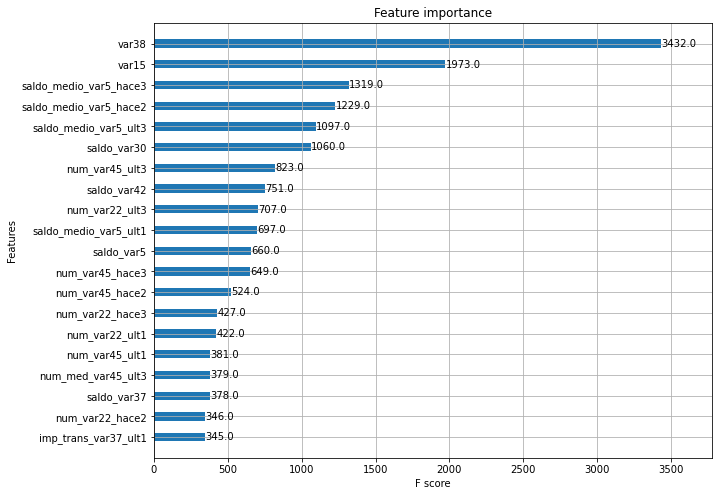

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)